# [Nonconformist Dice](https://fivethirtyeight.com/features/its-elementary-my-dear-riddler/)

You have four fair tetrahedral dice whose four sides are numbered 1 through 4.

You play a game in which you roll them all and divide them into two groups: those whose values are unique, and those which are duplicates. For example, if you roll a 1, 2, 2 and 4, then the 1 and 4 will go into the “unique” group, while the 2s will go into the “duplicate” group.

Next, you reroll all the dice in the duplicate pool and sort all the dice again. Continuing the previous example, that would mean you reroll the 2s. If the result happens to be 1 and 3, then the “unique” group will now consist of 3 and 4, while the “duplicate” group will have two 1s.

You continue rerolling the duplicate pool and sorting all the dice until all the dice are members of the same group. If all four dice are in the “unique” group, you win. If all four are in the “duplicate” group, you lose.

What is your probability of winning the game?

# Solution

In [1]:
from itertools import combinations, permutations, product, accumulate
from collections import Counter
from fractions import Fraction
from random import randint
from matplotlib import pyplot as plt

four_rolls = list(product(*(list(range(4)) for _ in range(4))))

def duplicates(x):
    return sum(v for _, v in Counter(x).items() if v > 1)

There are two key observations:

### Observation 1
Because we only care about duplicates, the game state at a given roll after the first is completely determined by _how many duplicate dice are there_. Hence, there are only four distinct, non-initial game states, which we shall call $S_0, S_2, S_3, S_4$ where $S_n$ is the state with $n$ duplicate dice. Notice that there can not be a state with one duplicate die. Furthermore, $S_0$ is the winning state and $S_4$ is the losing state.
 
### Observation 2
Because of Observation 1, rolling four dice is the same as rolling three dice. This is because the game state is trivially invariant under adding $1$ modulo $4$ to all dice.

## The initial roll
Let us consider the initial roll. There are four cases:

### Case 1: 0 duplicates, 4 uniques
This happens with probability: 
$$
\frac{1}{256} \times 4! = \frac{3}{32}
$$

In [2]:
Fraction(sum(1 for x in four_rolls if duplicates(x) == 0), len(four_rolls))

Fraction(3, 32)

### Case 2: 2 duplicates, 2 uniques
The simplest way to see it is to observe that we may choose in ${4 \choose 2}$ ways which dice form the pair, and in $4$ ways what is their value. At that point, we may choose in $3 \times 2$ ways the value of the remaining two dice.
Therefore case 2 happens with probability:
$$
\frac{1}{256} \times 4 \times (3 \times 2) \times {4 \choose 2} = \frac{9}{16}
$$

In [3]:
Fraction(sum(1 for x in four_rolls if duplicates(x) == 2), len(four_rolls))

Fraction(9, 16)

### Case 3: 3 duplicates, 1 unique
Like above, this happens with probability 
$$
\frac{1}{256} \times {4 \choose 3} \times (4 \times 3) = \frac{3}{16}
$$

In [4]:
Fraction(sum(1 for x in four_rolls if duplicates(x) == 3), len(four_rolls))

Fraction(3, 16)

### Case 4: 4 duplicates
This can happen in two ways, if all four dice are the same, with probability $\frac{1}{256} \times 4 = \frac{1}{64}$, or if there are two pairs, which has probability $\frac{1}{256} \times {4 \choose 2} \times (4 \times 3) / 2 = \frac{9}{64}$; the total is $\frac{1}{64} + \frac{9}{64} = \frac{5}{32}$.

In [5]:
Fraction(sum(1 for x in four_rolls if duplicates(x) == 4), len(four_rolls))

Fraction(5, 32)

Therefore, if we let $p(S_n)$ be the probability of winning the game conditional on being at state $S_n$, we may write:

$$
p(\text{Init}) = p(S_3) = \frac{3}{32} + \frac{9}{16} p(S_2) + \frac{3}{16} p(S_3)
$$

## Rolling from two duplicates
If there are two duplicate dice, we are only rolling two dice. We may assume without loss of generality that the unrolled dice are a one and a two. There are $16$ unique rolls of two dice. It's easy to see that in $2$ cases we go to $S_4$ (with rolls $(1, 2)$ or $(2, 1)$), in 2 cases we go to $S_0$ (with rolls $(3, 4)$ or $(4, 3)$), and in 2 cases we go to $S_3$ (with rolls $(1, 1)$ or $(2, 2)$). In the remaining $10$ cases we go to $S_2$ again.

In [6]:
two_rolls = list((a, b, c, d) for a, b, c, d in four_rolls if a == 1 and b == 2)
{
    j: sum(1 for x in two_rolls if duplicates(x) == j)
    for j in (0, 2, 3, 4)
}

{0: 2, 2: 10, 3: 2, 4: 2}

Therefore, with the same convention as above, we may write:

$$
p(S_2) = \frac{1}{8} + \frac{5}{8} p(S_2) + \frac{1}{8} p(S_3)
$$

This equation, toghether with the previous one, forms a linear system that is easily solvable:

$$
\begin{cases}
\begin{array}{rcl}
p(S_3) & = & \frac{3}{32} + \frac{9}{16} p(S_2) + \frac{3}{16} p(S_3) \\
p(S_2) & = & \frac{1}{8} + \frac{5}{8} p(S_2) + \frac{1}{8} p(S_3) \\
\end{array}
\end{cases}
$$

Yielding, after trivial algebraic manipulations, $p(S_3) = p(\text{Init}) = \frac{9}{20}$

## Simulator

In [7]:
def roll():
    return randint(1, 4)

def play():
    x = Counter((roll() for _ in range(4)))
    while True:
        if all(c == 1 for _, c in x.items()):
            return True
        if all(c % 2 == 0 for _, c in x.items()):
            return False
        for k, v in Counter(x).items():
            if v >= 2:
                x[k] = 0
                x.update(Counter((roll() for _ in range(v))))

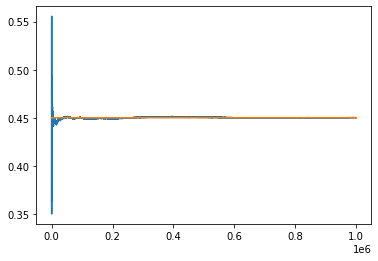

In [9]:
N = 1_000_000
X = list(play() for _ in range(N))
Wr = [w/n for n, w in enumerate(list(accumulate(X)), 1)]
plt.plot(range(10, N), Wr[10:], [9/20 for _ in range(10, N)])